# IS 4487 Assignment 9: Customer Segmentation with Clustering

In this assignment, you will:
- Apply unsupervised learning to explore patterns in hotel booking behavior
- Use K-Means and Gaussian Mixture Models (GMM) for customer segmentation
- Evaluate model quality with metrics like Silhouette Score and Davies-Bouldin Index
- Connect clustering to actionable business insights

## Why This Matters

Businesses like hotels and travel platforms (e.g., Airbnb or Expedia) rely on customer segmentation to tailor promotions, pricing strategies, and service levels. Unlike supervised models, clustering helps uncover patterns when no labels exist—an ideal tool when entering new markets or analyzing unstructured customer behavior.

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Assignments/assignment_09_clustering.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## Dataset Description: Hotel Bookings

This dataset contains booking information for two types of hotels: a **city hotel** and a **resort hotel**. Each record corresponds to a single booking and includes various details about the reservation, customer demographics, booking source, and whether the booking was canceled.

**Source**: [GitHub - TidyTuesday: Hotel Bookings](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md)

### Key Use Cases
- Understand customer booking behavior
- Explore factors related to cancellations
- Segment guests based on booking characteristics
- Compare city vs. resort hotel performance

### Data Dictionary

| Variable | Type | Description |
|----------|------|-------------|
| `hotel` | character | Hotel type: City or Resort |
| `is_canceled` | integer | 1 = Canceled, 0 = Not Canceled |
| `lead_time` | integer | Days between booking and arrival |
| `arrival_date_year` | integer | Year of arrival |
| `arrival_date_month` | character | Month of arrival |
| `stays_in_weekend_nights` | integer | Nights stayed on weekends |
| `stays_in_week_nights` | integer | Nights stayed on weekdays |
| `adults` | integer | Number of adults |
| `children` | integer | Number of children |
| `babies` | integer | Number of babies |
| `meal` | character | Type of meal booked |
| `country` | character | Country code of origin |
| `market_segment` | character | Booking source (e.g., Direct, Online TA) |
| `distribution_channel` | character | Booking channel used |
| `is_repeated_guest` | integer | 1 = Repeated guest, 0 = New guest |
| `previous_cancellations` | integer | Past booking cancellations |
| `previous_bookings_not_canceled` | integer | Past bookings not canceled |
| `reserved_room_type` | character | Initially reserved room type |
| `assigned_room_type` | character | Room type assigned at check-in |
| `booking_changes` | integer | Number of booking modifications |
| `deposit_type` | character | Deposit type (No Deposit, Non-Refund, etc.) |
| `agent` | character | Agent ID who made the booking |
| `company` | character | Company ID (if booking through company) |
| `days_in_waiting_list` | integer | Days on the waiting list |
| `customer_type` | character | Booking type: Contract, Transient, etc. |
| `adr` | float | Average Daily Rate (price per night) |
| `required_car_parking_spaces` | integer | Requested parking spots |
| `total_of_special_requests` | integer | Number of special requests made |
| `reservation_status` | character | Final status (Canceled, No-Show, Check-Out) |
| `reservation_status_date` | date | Date of the last status update |

This dataset is ideal for classification, segmentation, and trend analysis exercises.

## 1. Setup and Load Data

Business framing:  

Before we can cluster or segment anything, we need clean, accessible data in a usable format.

- Import the necessary Python libraries
- Load the hotel bookings dataset by [downloading the file](https://github.com/rfordatascience/tidytuesday/blob/main/data/2020/2020-02-11/readme.md#get-the-data-here) or using this link: https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2020/2020-02-11/hotels.csv
- Display the first few rows

### In Your Response:
1. What stands out in the initial preview? Any columns or rows that seem unusual?

In [7]:
import pandas as pd

# Load the data
hotels = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2020/2020-02-11/hotels.csv')

# Display the first few rows
display(hotels.head())

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


### ✍️ Your Response: 🔧
1. The first things that seem unusual are lead_time, company, agent, and cancellations. Lead_time has a few very large lead times, which are odd bookings. Company and agent seem to be missing data, and cancellations contains a large portion of "is_canceled" bookings, which could skew certain analyses if it's not accounted for.

## 2. Select and Prepare Features

Business framing:  

A hotel might want to group guests based on how long they stay, how far in advance they book, or how likely they are to make special requests. You need to pick variables that represent meaningful guest behavior.

- Choose 3–5 numeric features related to customer behavior
- Drop missing values if needed
- Standardize using `StandardScaler`

### In Your Response:
1. What features did you select and why?
2. What kinds of patterns or segments do you expect to find?


In [8]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Choose numeric features related to customer behavior
features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adr', 'total_of_special_requests']
X = hotels[features].copy()

# Drop rows with missing values in the selected features
X.dropna(inplace=True)

# Handle potential infinite values in adr
X['adr'] = X['adr'].replace([np.inf, -np.inf], np.nan)
X.dropna(inplace=True)


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display the first few rows of the scaled data
display(pd.DataFrame(X_scaled, columns=features).head())

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adr,total_of_special_requests
0,2.227051,-0.92889,-1.310240,-2.015038,-0.720694
1,5.923385,-0.92889,-1.310240,-2.015038,-0.720694
2,-0.907814,-0.92889,-0.786207,-0.530935,-0.720694
3,-0.851667,-0.92889,-0.786207,-0.530935,-0.720694
4,-0.842309,-0.92889,-0.262174,-0.075810,0.540666


### ✍️ Your Response: 🔧
1. I selected lead_time to indicate spontaneous vs planner type travelers, stays_in_weekend_nights and stays_in_week_nights to help caputre the duration and type of stay, which could help differentiate between types of travelers, adr, which can help to segment customers by budget or luxury preference, and total_of_special_requests to help indicate customer engagement and specific needs.

2. Based on these features, I expected to find things like customers who book last minute for short stays and customers who book well in advance for longer stays, budget-conscious travelers, and travelers who require specific accomodations or services.


## 3. Apply K-Means Clustering

Business framing:  

Let’s say you’re working with the hotel’s marketing manager. She wants to group guests into a few clear types to target email campaigns. K-Means is a fast, simple way to try this.

- Fit a `KMeans` model with your selected features
- Choose a value of `k` (e.g. 3, 4, or 5)
- Predict clusters and assign to each guest
- Visualize using a scatterplot of 2 features

Much of this assignment has already been covered in the lab. Please be sure to complete the lab before the assignment.

### In Your Response:
1. What `k` value did you choose, and how did you decide?
2. What types of customers seem to show up in the clusters?



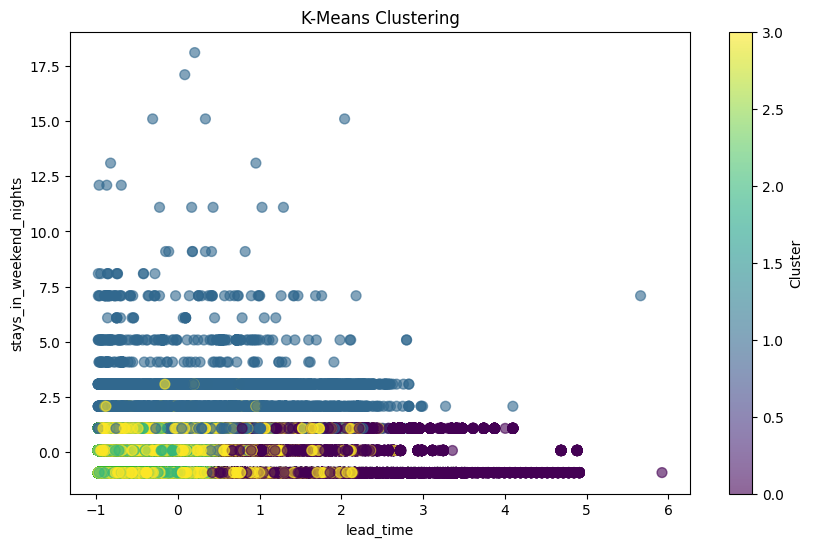

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Choose a value for k
k = 4

# Fit KMeans model
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
hotels['kmeans_cluster'] = clusters

# Visualize the clusters (using the first two features for simplicity)
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', marker='o', s=50, alpha=0.6)
plt.title('K-Means Clustering')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.colorbar(label='Cluster')
plt.show()

### ✍️ Your Response: 🔧
1. I chose a k value of 4 for the KMeans clustering because it's a good starting point to create a few distinct groups for the marketing manager.

2. It looks like the clusters might represent different combinations of lead_time and stays_in_weekend_nights.


## 4. Apply Gaussian Mixture Model (GMM)

Business framing:  

Not all guests fit neatly into one cluster. GMM lets us capture uncertainty — useful if customers behave similarly across groups.

- Fit a GMM with the same number of clusters you chose in Part 3
- Predict soft clusters (remember that soft clustering deals with probabilities, not labels)
- Visualize the GMM model so that you may compare it to the KMeans scatterplot

### In Your Response:
1. How did the GMM results compare to KMeans?
2. What business questions might GMM help answer better?


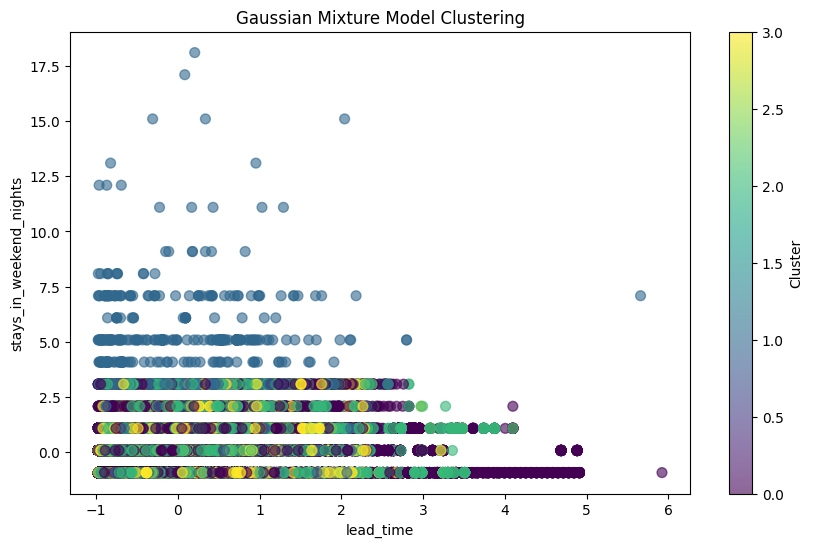

In [10]:
from sklearn.mixture import GaussianMixture

# Fit GMM model with the same number of clusters as KMeans
gmm = GaussianMixture(n_components=k, random_state=42)
gmm.fit(X_scaled)

# Predict soft clusters (probabilities)
gmm_probs = gmm.predict_proba(X_scaled)

# For visualization, we can assign each data point to the cluster with the highest probability
gmm_clusters = gmm_probs.argmax(axis=1)

# Visualize the GMM clusters (using the first two features for simplicity)
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=gmm_clusters, cmap='viridis', marker='o', s=50, alpha=0.6)
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.colorbar(label='Cluster')
plt.show()

### ✍️ Your Response: 🔧
1. The GMM can create more flexible clusters while the K-Means does the opposite. This is because GMM assumes the data within each cluster follows a Gaussian distribution, which allows for clusters of different sizes and shapes.

2.GMM can help understand customer behavior in scenarios of overlapping preferences, help identify customer segments with varying levels of uncertainty in their booking patterns, and analyze complex customer journeys where they might act like multiple groups at different times.


## 5. Evaluate Your Models

Business framing:  

In business, models should be both useful and reliable. You’ll compare model quality using standard evaluation metrics.

- Calculate:
  - WCSS
  - Silhouette Score
  - Davies-Bouldin Index
- Compare both models

**Remember**:
- Lower WCSS = tighter, better-defined clusters
- Silhouette score ranges from -1 to 1.  Higher values = better clustering
- Lower Davies-Boulding Index = better clustering

### In Your Response:
1. Which model performed better on the metrics?
2. Would you recommend KMeans or GMM for a business analyst? Why?


In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Calculate WCSS for K-Means
wcss = kmeans.inertia_

# Calculate Silhouette Score for KMeans
silhouette_kmeans = silhouette_score(X_scaled, clusters)

# Calculate Davies-Bouldin Index for KMeans
davies_bouldin_kmeans = davies_bouldin_score(X_scaled, clusters)

# For GMM, we can use the predicted hard clusters for these metrics
silhouette_gmm = silhouette_score(X_scaled, gmm_clusters)
davies_bouldin_gmm = davies_bouldin_score(X_scaled, gmm_clusters)


print(f"K-Means WCSS: {wcss}")
print(f"K-Means Silhouette Score: {silhouette_kmeans}")
print(f"K-Means Davies-Bouldin Index: {davies_bouldin_kmeans}")
print("-" * 30)
print(f"GMM Silhouette Score: {silhouette_gmm}")
print(f"GMM Davies-Bouldin Index: {davies_bouldin_gmm}")

### ✍️ Your Response: 🔧
1.

2.


## 6. Business Interpretation

Business framing:  

What do these clusters mean in the real world? Could they represent solo travelers, families, or bargain shoppers?

- Review characteristics of each cluster (e.g. average `lead_time`, `special_requests`)
- Think from a marketing or hotel operations perspective

### In Your Response:
1. What do the segments represent in terms of guest behavior?
2. How could the hotel tailor services or promotions to each group?


In [ ]:
# Add KMeans cluster labels to the original dataframe (already done in a previous step, but ensuring it exists)
if 'kmeans_cluster' not in hotels.columns:
    hotels['kmeans_cluster'] = clusters # Assuming 'clusters' from the KMeans step is available

# Analyze cluster characteristics
cluster_characteristics = hotels.groupby('kmeans_cluster')[features].mean()
display(cluster_characteristics)

### ✍️ Your Response: 🔧
1.

2.


## 7. Final Reflection

Business framing:  

Many teams ask for "segmentation" without knowing how it works. You now have hands-on experience with two clustering techniques and how to present the results.

### In Your Response:
1. What was most challenging about unsupervised learning?
2. When would you use clustering instead of supervised models?
3. How would you explain the value of clustering to a non-technical manager?
4. How does this relate to your customized learning outcome you created in canvas?


### ✍️ Your Response: 🔧
1.

2.

3.

4.

## Submission Instructions

✅ **Before submitting:**
- Make sure all code cells are run and outputs are visible  
- All markdown questions are answered thoughtfully  
- Submit the assignment as an **HTML file** on Canvas


In [ ]:
!jupyter nbconvert --to html "assignment_09_LastnameFirstname.ipynb"